In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from src.classes import HitBox, TankProperties32x2
from src.dataprocessing import get_measured_potential
from src.vae_model import vae_model
from src.visualization import (
    plot_latent_space_with_tsne,
    plot_loss_history,
    plot_meas_coords,
    plot_meas_coords_wball,
    plot_mesh,
    plot_rball,
    plot_voxel,
)
from src.voxel_util import (
    gen_voxel_ball_data,
    gen_voxel_brick_data,
    random_voxel_ball,
    random_voxel_brick,
    read_json_file,
    scale_realworld_to_intdomain,
    voxel_ball,
)
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

2024-01-03 09:47:46.496030: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 09:47:46.496128: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 09:47:46.496937: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 09:47:46.581155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# sources
# https://github.com/IsaacGuan/3D-VAE/blob/master/train.py
# https://github.com/ffriese/voxel_vae/tree/master
# https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/Generative/VAE.py

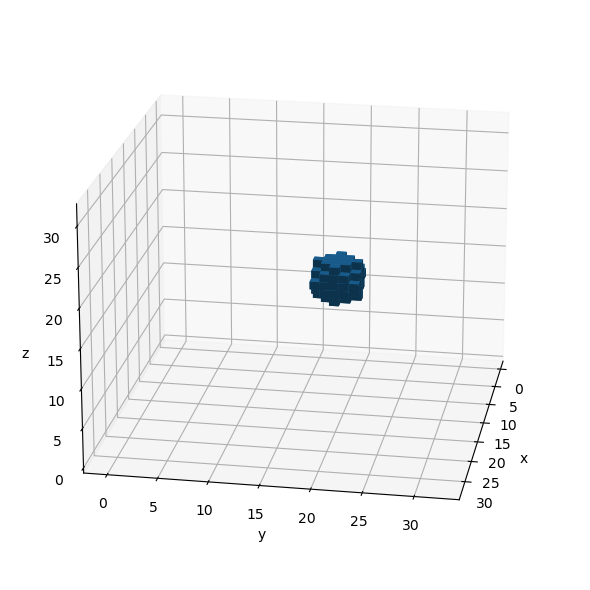

In [3]:
ball = True
if ball:
    d = 3
    plot_voxel(random_voxel_ball(d=d))
else:
    d_xyz = [5, 5, 5]
    plot_voxel(random_voxel_brick(d_xyz=d_xyz))

In [17]:
n_gammas = 800
if ball:
    gamma_train = gen_voxel_ball_data(num=n_gammas, d=d)
else:
    gamma_train = gen_voxel_brick_data(num=n_gammas, d_xyz=d_xyz)

print(gamma_train.shape)

(800, 32, 32, 32, 1)


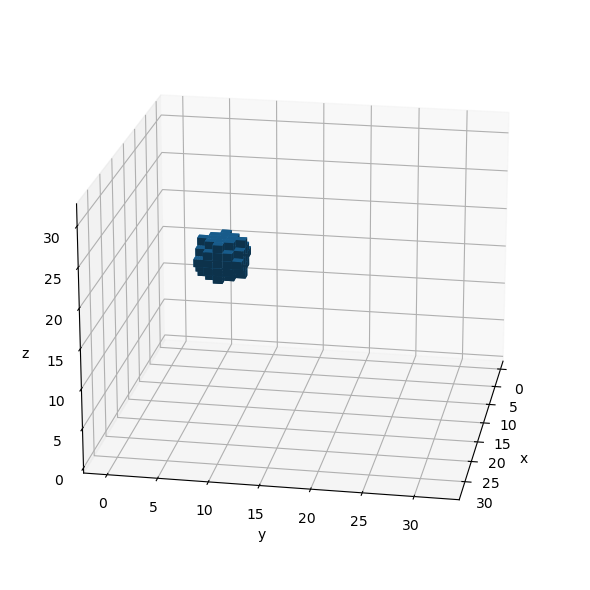

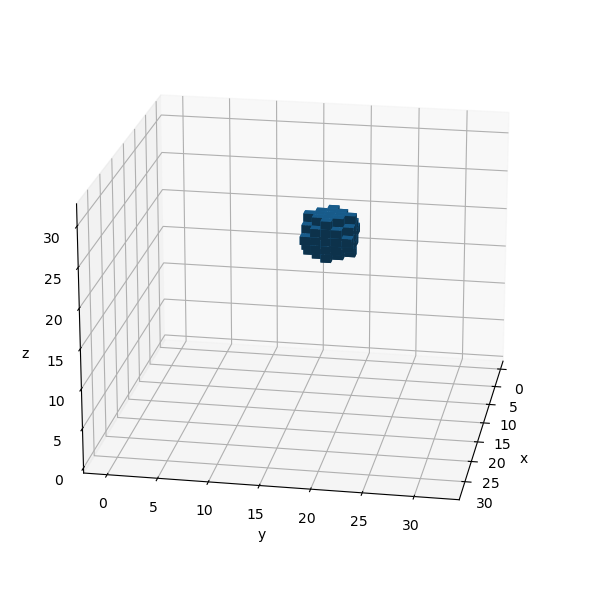

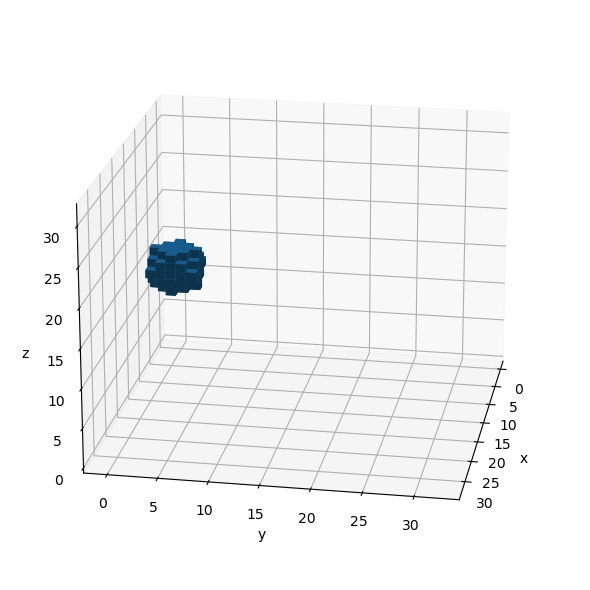

In [18]:
ns = 100
for idx in np.random.randint(0, ns, size=3):
    plot_voxel(gamma_train[idx, :, :, :, 0])

In [34]:
vae = vae_model(input_shape=(32, 32, 32, 1), beta=1.05)
vae.compile(optimizer=Adam())
epochs = 500
batch_size = 128

cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=0, start_from_epoch=470)

history = vae.fit(gamma_train, epochs=epochs, batch_size=batch_size, callbacks=[cb])

Epoch 1/500
7/7 [==============================] - 5s 27ms/step - loss: 918.9517 - reconstruction_loss: 875.4855 - kl_loss: 0.0036 - total_loss: 877.5643
Epoch 2/500
7/7 [==============================] - 0s 26ms/step - loss: 795.6919 - reconstruction_loss: 795.8744 - kl_loss: 0.0126 - total_loss: 795.5383
Epoch 3/500
7/7 [==============================] - 0s 26ms/step - loss: 793.4487 - reconstruction_loss: 785.4684 - kl_loss: 0.0805 - total_loss: 786.6404
Epoch 4/500
7/7 [==============================] - 0s 27ms/step - loss: 750.3529 - reconstruction_loss: 737.5762 - kl_loss: 0.8211 - total_loss: 739.2956
Epoch 5/500
7/7 [==============================] - 0s 25ms/step - loss: 693.6634 - reconstruction_loss: 677.3337 - kl_loss: 5.8030 - total_loss: 683.7098
Epoch 6/500
7/7 [==============================] - 0s 26ms/step - loss: 666.0138 - reconstruction_loss: 650.8698 - kl_loss: 12.5286 - total_loss: 663.9519
Epoch 7/500
7/7 [==============================] - 0s 25ms/step - loss: 660

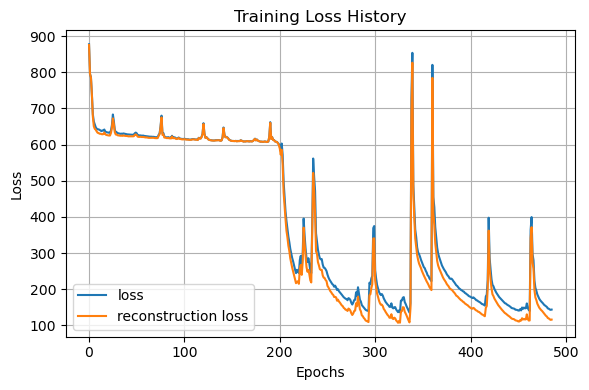

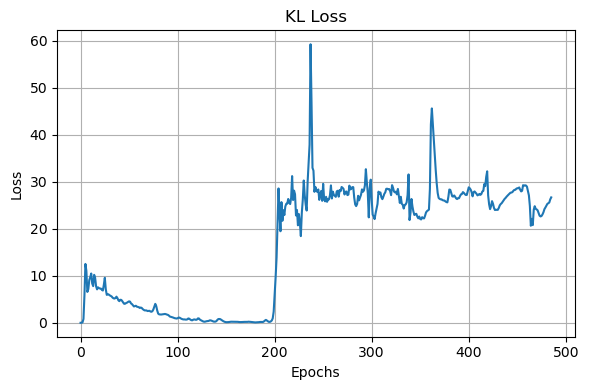

In [35]:
plot_loss_history(history)

plt.figure(figsize=(6, 4))
plt.title("KL Loss")
plt.plot(history.history["kl_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()
plt.show()

In [36]:
if ball:
    gamma_test = gen_voxel_ball_data(num=100, d=d)
else:
    gamma_test = gen_voxel_brick_data(num=100, d_xyz=d_xyz)

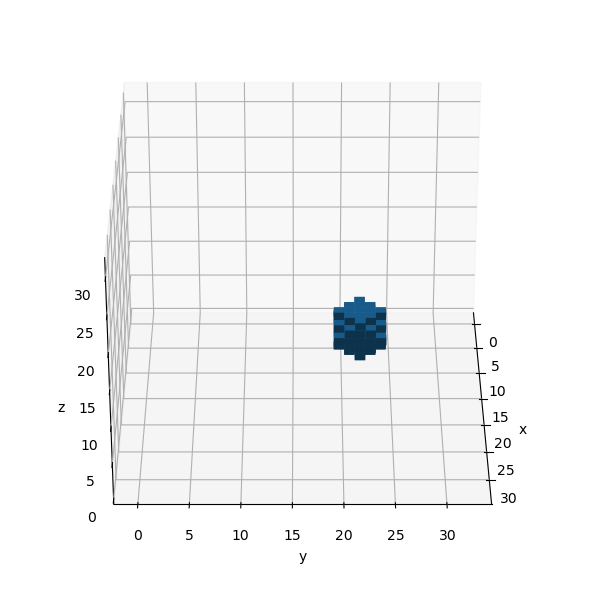

1/1 [==============================] - 0s 18ms/step


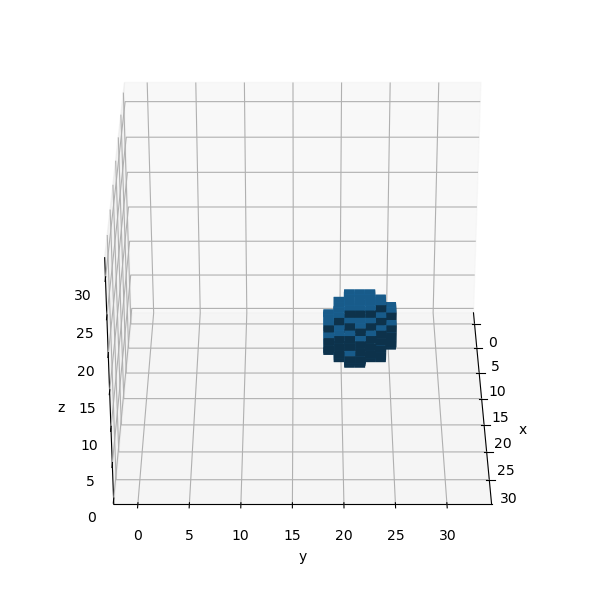

In [41]:
if ball:
    sgl_data = gen_voxel_ball_data(1, d=d)
else:
    sgl_data = gen_voxel_brick_data(1, d_xyz=d_xyz)
# plot original
plot_voxel(sgl_data[0, :, :, :, 0], azim=0, elev=30)
z_mean, z_log_var, z = vae.encoder.predict(sgl_data)

# plot prediction
sgl_pred = vae.decoder.predict(z)
sgl_pred = np.squeeze(sgl_pred, axis=4)
sgl_pred = np.squeeze(sgl_pred, axis=0)
# sgl_pred = np.abs(np.round(sgl_pred))
sgl_pred = np.clip(sgl_pred, a_min=0, a_max=1)

plot_voxel(sgl_pred, azim=0, elev=30)

In [42]:
vae.save_weights("models/vae_weights_beta.h5")
vae.save("models/vae_beta.keras")

/home/jath/.conda/envs/TF2_12/lib/python3.11/site-packages/keras/src/saving/saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


## Load VAE

## Build Mapper

In [43]:
l_path = "measurements/acryl_skip_8_d_30/"

json_data = read_json_file(l_path + "info.json")
hitbox = HitBox(**json_data["HitBox"])
tank = TankProperties32x2(**json_data["TankProperties32x2"])

In [44]:
empty_tank_before = list()
for path in np.sort(glob.glob(l_path + "empty_tank/b*")):
    print(path)
    tmp = np.load(path, allow_pickle=True)
    empty_tank_before.append(np.abs(get_measured_potential(tmp, shape_type="vector")))
empty_tank_before = np.array(empty_tank_before)

empty_tank_after = list()
for path in np.sort(glob.glob(l_path + "empty_tank/a*")):
    print(path)
    tmp = np.load(path, allow_pickle=True)
    empty_tank_after.append(np.abs(get_measured_potential(tmp, shape_type="vector")))
empty_tank_after = np.array(empty_tank_after)

measurements/acryl_skip_8_d_30/empty_tank/before_000000.npz
measurements/acryl_skip_8_d_30/empty_tank/before_000001.npz
measurements/acryl_skip_8_d_30/empty_tank/before_000002.npz
measurements/acryl_skip_8_d_30/empty_tank/before_000003.npz
measurements/acryl_skip_8_d_30/empty_tank/before_000004.npz
measurements/acryl_skip_8_d_30/empty_tank/after_000000.npz
measurements/acryl_skip_8_d_30/empty_tank/after_000001.npz
measurements/acryl_skip_8_d_30/empty_tank/after_000002.npz
measurements/acryl_skip_8_d_30/empty_tank/after_000003.npz
measurements/acryl_skip_8_d_30/empty_tank/after_000004.npz


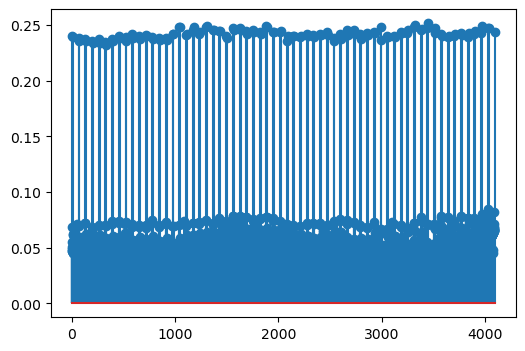

In [45]:
mean_bf = np.mean(empty_tank_before[1:], axis=0)
mean_af = np.mean(empty_tank_after[:], axis=0)
# mean ground value:
mean_ground = np.mean([mean_bf, mean_af], axis=0)
plt.figure(figsize=(6, 4))
plt.stem(mean_ground)
plt.show()

In [46]:
φ = list()
γ = list()

for path in tqdm(np.sort(glob.glob(l_path + "data/*"))):
    tmp = np.load(path, allow_pickle=True)
    φ.append(np.abs(get_measured_potential(tmp, shape_type="vector")) - mean_ground)
    ball = tmp["anomaly"].tolist()
    coordinate = [ball.y, ball.x, ball.z]
    d = 4
    x0, y0, z0 = scale_realworld_to_intdomain(coordinate, hitbox, d=d)
    γ.append(voxel_ball(y0, x0, z0, d=d))

γ = np.array(γ)
φ = np.array(φ)

_, _, z = vae.encoder.predict(np.expand_dims(γ, axis=4))

100%|██████████| 7450/7450 [01:16<00:00, 97.70it/s] 


233/233 [==============================] - 1s 5ms/step


<StemContainer object of 3 artists>

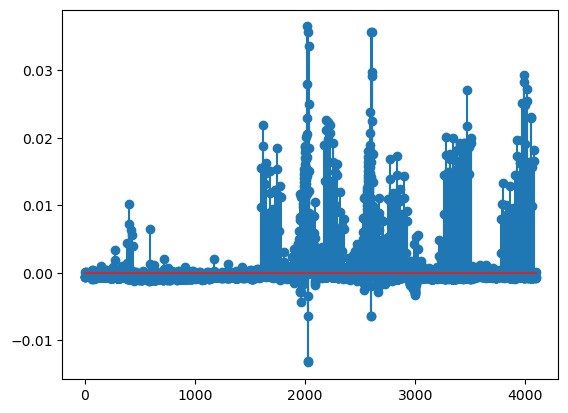

In [47]:
plt.stem(φ[0, :])

In [48]:
φ_train, φ_test, z_train, z_test, γ_train, γ_test = train_test_split(
    φ,
    z,
    γ,
    test_size=0.05,
    random_state=42,
    shuffle=True,
)

In [49]:
print(
    φ_train.shape,
    φ_test.shape,
    z_train.shape,
    z_test.shape,
    γ_train.shape,
    γ_test.shape,
)

(7077, 4096) (373, 4096) (7077, 8) (373, 8) (7077, 32, 32, 32) (373, 32, 32, 32)


In [50]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

phi_scaler = tf.keras.layers.Normalization()
phi_scaler.adapt(φ)

def mapper(input_shape=(4096,), latent_dim=8):
    mapper_inputs = layers.Input(shape=input_shape)
    x = phi_scaler(mapper_inputs)

    # x = layers.Dense(2**11)(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dense(units=32, activation="relu")(x)
    # x = layers.Dense(2**7)(x)
    x = layers.Dense(units=16, activation="relu")(x)
        
    x = layers.Dense(latent_dim, activation="linear")(x)

    return Model(mapper_inputs, x)


mapper = mapper()
mapper.compile(Adam(), loss=tf.keras.losses.mean_squared_error, metrics=["mse"])
mapper.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 4096)]            0         
                                                                 
 normalization (Normalizati  (None, 4096)              8193      
 on)                                                             
                                                                 
 dense_4 (Dense)             (None, 128)               524416    
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                             

In [51]:
history_mapper = mapper.fit(φ_train, z_train, epochs=150, batch_size=100)

Epoch 1/150
71/71 [==============================] - 2s 4ms/step - loss: 7.6380 - mse: 7.6380
Epoch 2/150
71/71 [==============================] - 0s 5ms/step - loss: 3.0834 - mse: 3.0834
Epoch 3/150
71/71 [==============================] - 0s 5ms/step - loss: 1.7930 - mse: 1.7930
Epoch 4/150
71/71 [==============================] - 0s 5ms/step - loss: 1.1726 - mse: 1.1726
Epoch 5/150
71/71 [==============================] - 0s 5ms/step - loss: 0.9040 - mse: 0.9040
Epoch 6/150
71/71 [==============================] - 0s 5ms/step - loss: 0.7243 - mse: 0.7243
Epoch 7/150
71/71 [==============================] - 0s 5ms/step - loss: 0.6503 - mse: 0.6503
Epoch 8/150
71/71 [==============================] - 0s 5ms/step - loss: 0.5575 - mse: 0.5575
Epoch 9/150
71/71 [==============================] - 0s 5ms/step - loss: 0.4735 - mse: 0.4735
Epoch 10/150
71/71 [==============================] - 0s 5ms/step - loss: 0.4315 - mse: 0.4315
Epoch 11/150
71/71 [==============================] - 0s 5m

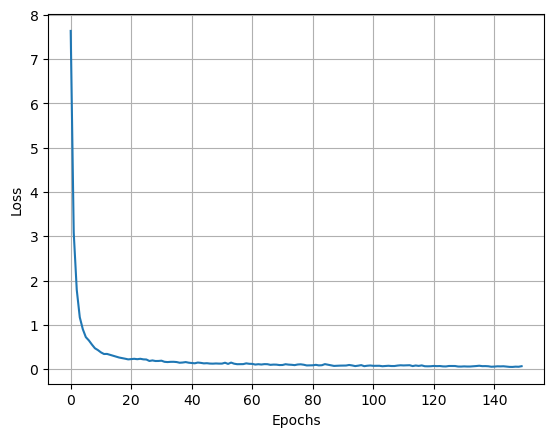

In [52]:
plt.plot(history_mapper.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [53]:
# mapper.save("models/mapper.keras")

In [54]:
# mapper = tf.keras.models.load_model("models/mapper.keras")

In [55]:
γ_pred = vae.decoder.predict(mapper.predict(φ_test))
γ_pred = np.round(γ_pred, 2)
γ_pred = np.clip(γ_pred, a_min=0, a_max=1)

12/12 [==============================] - 0s 2ms/step


In [56]:
print(γ_pred.shape, np.min(γ_pred), np.max(γ_pred))

(373, 32, 32, 32, 1) 0.0 1.0


68 
 predicted:


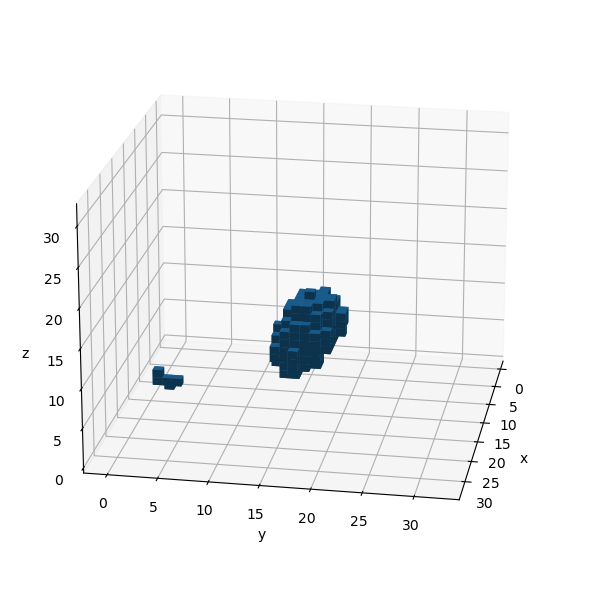

ground truth


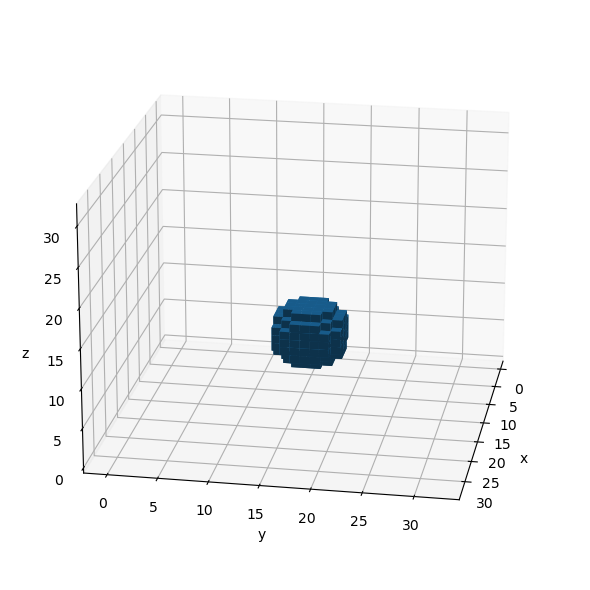

195 
 predicted:


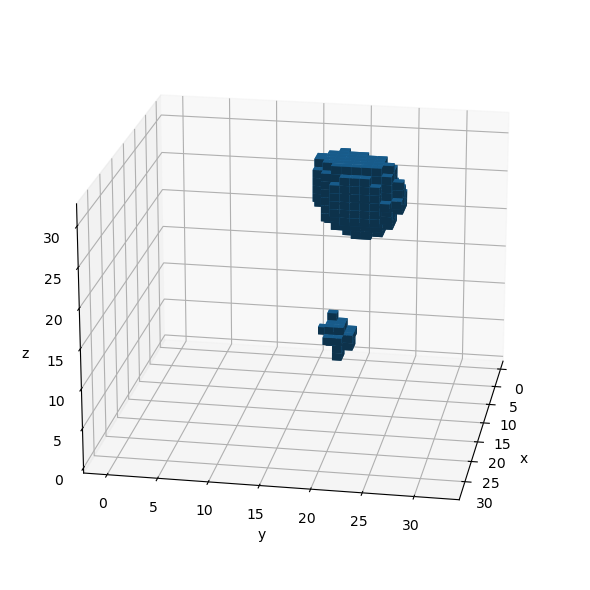

ground truth


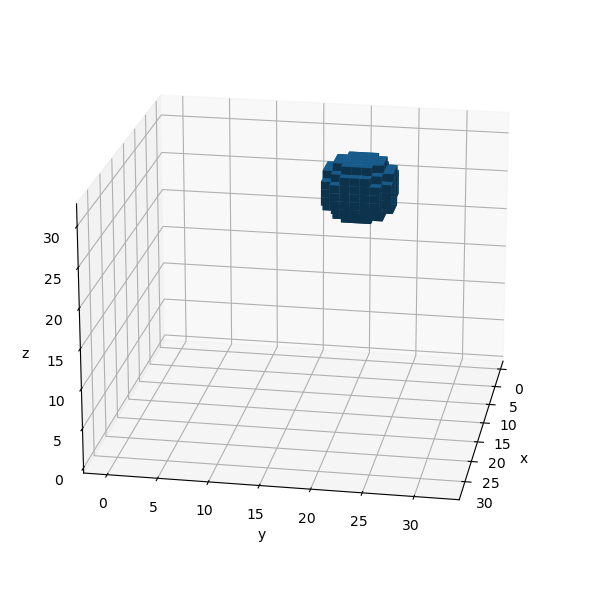

64 
 predicted:


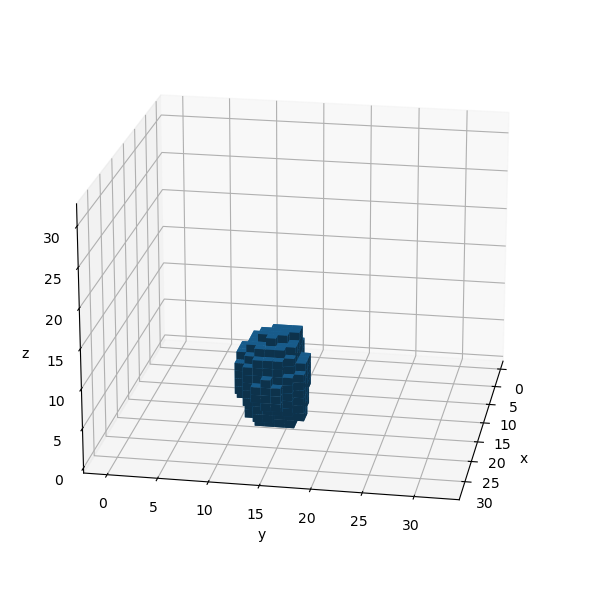

ground truth


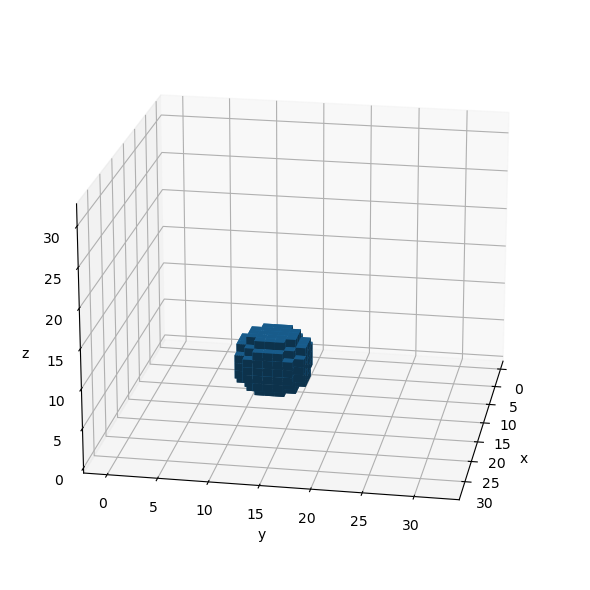

272 
 predicted:


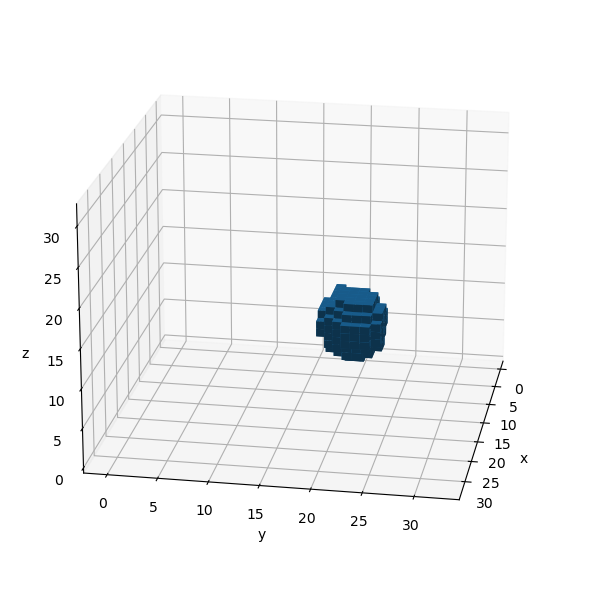

ground truth


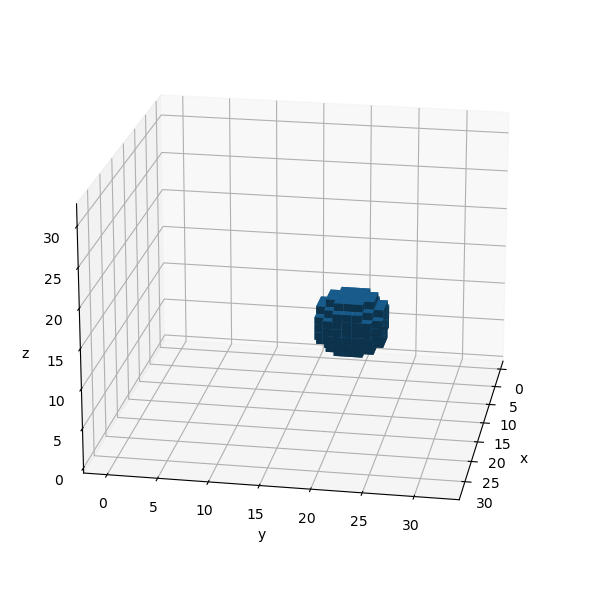

300 
 predicted:


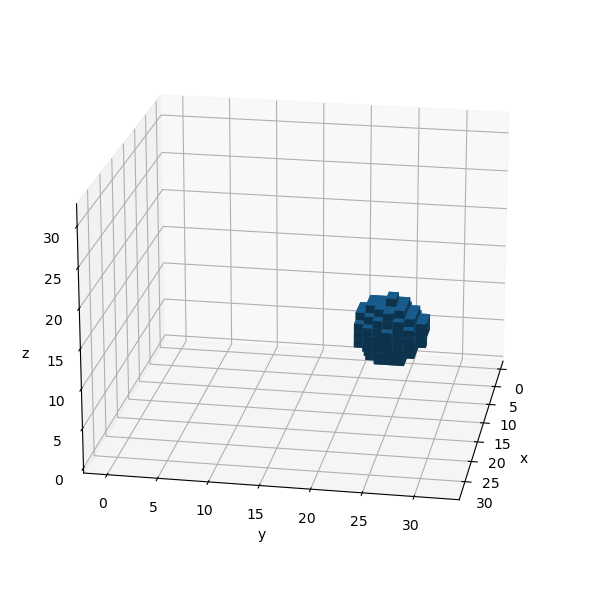

ground truth


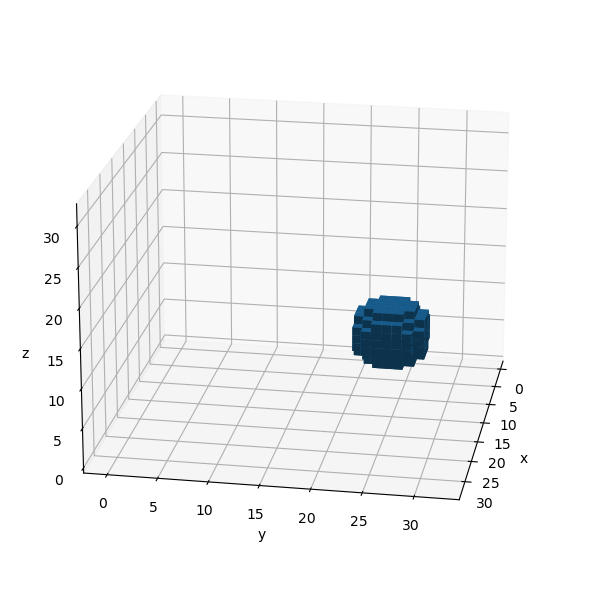

In [57]:
for idx in np.random.randint(0, γ_pred.shape[0], 5):
    print(idx, "\n predicted:")
    plot_voxel(γ_pred[idx, :, :, :, 0])
    print("ground truth")
    plot_voxel(γ_test[idx])

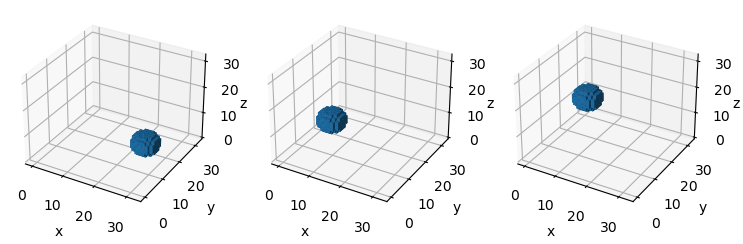

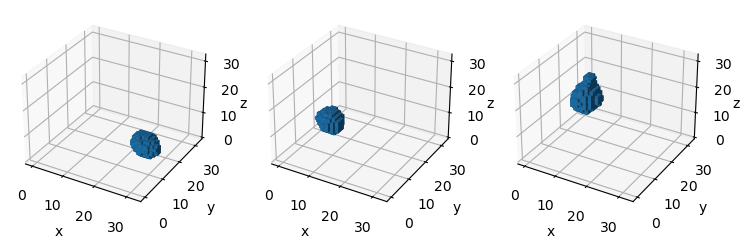

In [78]:
def subplot_plot_voxel(ax, voxel_matrix):
    ax.voxels(voxel_matrix)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.text(43, 43, 10, 'z', horizontalalignment='center')
    

fig, axs = plt.subplots(1, 3, figsize=(9, 2.7), subplot_kw={'projection': '3d'})
for a, i in enumerate([237,287,4]):
    subplot_plot_voxel(axs[a], γ_test[i])
#axs[1].set_title('True')
#plt.tight_layout()
plt.savefig("images/true_gamma.pdf")
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(9, 2.7), subplot_kw={'projection': '3d'})
for a, i in enumerate([237,287,4]):
    subplot_plot_voxel(axs[a], γ_pred[i, :, :, :, 0])
#axs[1].set_title('Prediction')
#plt.tight_layout()
plt.savefig("images/pred_gamma.pdf")
plt.show()

In [79]:
def compute_voxel_err(predicted_voxels, true_voxels):
    com_pred = center_of_mass(predicted_voxels)
    com_true = center_of_mass(true_voxels)

    return np.array(com_true) - np.array(com_pred)


def visualize_errors(errors, in_percent=True, voxel_val_max=32, save=False):
    if in_percent:
        errors = errors / voxel_val_max * 100
    data = {"x-pos": errors[:, 0], "y-pos": errors[:, 1], "z-pos": errors[:, 2]}
    df = pd.DataFrame(data)
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=df, showfliers=False)
    # plt.ylim([-1,3])
    if in_percent:
        plt.ylabel("Error (%)")
    else:
        plt.ylabel("Error (Voxel)")
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig("images/reconstruction_axis_error.pdf")
    plt.show()


def center_of_mass(voxel_matrix):
    x_coords, y_coords, z_coords = np.meshgrid(
        np.arange(voxel_matrix.shape[0]),
        np.arange(voxel_matrix.shape[1]),
        np.arange(voxel_matrix.shape[2]),
    )
    total_mass = np.sum(voxel_matrix)
    center_x = np.sum(x_coords * voxel_matrix) / total_mass
    center_y = np.sum(y_coords * voxel_matrix) / total_mass
    center_z = np.sum(z_coords * voxel_matrix) / total_mass

    return center_y, center_x, center_z

In [80]:
errors = list()
for i in range(γ_pred.shape[0]):
    errors.append(compute_voxel_err(γ_pred[i, :, :, :, 0], γ_test[i]))
errors = np.array(errors)

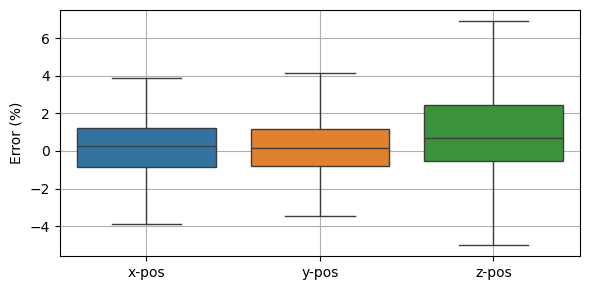

In [82]:
visualize_errors(errors, save=True)

In [83]:
print("std:\t", np.std(errors, axis=0))
print("mean:\t", np.mean(errors, axis=0))
print("var:\t", np.var(errors, axis=0))

std:	 [1.27358473 1.13459589 0.85415199]
mean:	 [0.02506196 0.14603851 0.34127221]
var:	 [1.62201807 1.28730784 0.72957563]


In [84]:
def compute_volume_error(true, pred):
    v_err = list()
    for i in range(γ_pred.shape[0]):
        ele_pred = len(np.where(pred[i, :, :, :, 0]!=0)[0])
        ele_true = len(np.where(true[i]!=0)[0])
        v_err.append(ele_pred-ele_true)
    v_err = np.array(v_err)
    return v_err

In [85]:
volumen_error = compute_volume_error(γ_test, γ_pred)

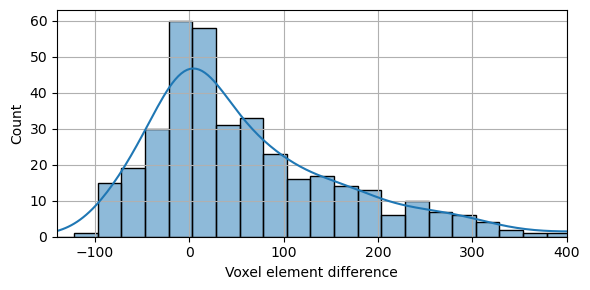

In [94]:
plt.figure(figsize=(6, 3))
sns.histplot(volumen_error, bins=25, kde=True)
plt.xlabel('Voxel element difference')
plt.xlim([-140,400])
plt.ylabel('Count')
plt.grid()
plt.tight_layout()
#plt.savefig("images/voxel_element_deviation.pdf")
# Show the plot
plt.show()

In [87]:
print("std:\t", np.std(volumen_error))
print("mean:\t", np.mean(volumen_error))
print("var:\t", np.var(volumen_error))

std:	 107.27820415022543
mean:	 62.63270777479893
var:	 11508.613085697447
